In [ ]:
"""
Import libraries
"""

import pandas as pd # for data manipulation
import numpy as np
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt # to plot the data
import seaborn as sns
from pylab import rcParams

import tensorflow as tf # to create the nn models

import datetime, os # for tensorBoard

from sklearn.metrics import mean_absolute_error # to check the performance

In [ ]:
"""
Settings
"""

startTest = 2000 # number of the sample where the test dataset starts
windowSize = 30  # Size of the window to slice the time series
batchSize = 128 # size of the batches
shuffleBufferSize = 1000 # number of points used to shuffle the data
tf.random.set_seed(13) # fix the seed to replicate the results

In [ ]:
"""
Helper functions
"""

# to plot the data
def plotTimeSeries(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# to plot the loss of each training epoch
def plotLoss(trainingHistory):
    loss=trainingHistory.history['loss']
    epochs=range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.title('Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# helper function that turns data into a window dataset
def sliceDatasetToWindows(timeSeries, windowSize, batchSize, shuffleBufferSize):
    ds = tf.data.Dataset.from_tensor_slices(timeSeries) # produce a tensor
    # split a the time series into windowSize slices with, a time shift of 1
    ds = ds.window(windowSize, shift=1, drop_remainder=True) 
    # define the batch 
    ds = ds.flat_map(lambda w: w.batch(windowSize))
    # use windowSize-1 points as features and the last point as label
    ds = ds.map(lambda w: (w[:-1], w[-1:])) 
    ds = ds.shuffle(shuffleBufferSize) # shuffle the data
    ds = ds.batch(batchSize).prefetch(1) # batching the dataset
    return ds

# to read the dataset shape
def shape(lst):
    def ishape(lst):
        shapes = [ishape(x) if isinstance(x, list) else [] for x in lst]
        shape = shapes[0]
        if shapes.count(shape) != len(shapes):
            raise ValueError('Ragged list')
        shape.append(len(lst))
        return shape
    return tuple(reversed(ishape(lst)))

# to make the forecasts
def model_forecast(model, timeSeries, windowSize, batchSize):
    ds = tf.data.Dataset.from_tensor_slices(timeSeries) # produce the tensor
    # split a the time series into windowSize slices with, a time shift of 1
    ds = ds.window(windowSize, shift=1, drop_remainder=True)  
    ds = ds.flat_map(lambda w: w.batch(windowSize))
    ds = ds.batch(batchSize).prefetch(1) # batching the dataset
    forecast = model.predict(ds) # make predictions
    return forecast

In [ ]:
"""
Load the dataset
"""

# prepare the figure
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

# load the dataset
csv_path = "https://raw.githubusercontent.com/fabiorubenn/DatasetForWorkshop21/main/coin_Bitcoin.csv"
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')

# plot the data
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [ ]:
"""
Pre-processing
"""

# standardize the data
scaledValueAtClose = StandardScaler().fit_transform(df.Close.values.reshape(-1, 1))
scaledValueAtClose = scaledValueAtClose[~np.isnan(scaledValueAtClose)]
scaledValueAtClose = scaledValueAtClose.reshape(-1, 1)

# plot the data
plt.plot(scaledValueAtClose)
plt.xlabel("Data points")
plt.ylabel("Standardized value")
plt.grid(True)

In [ ]:
"""
Produce the datasets
"""

# split the data
time = np.array(list(df.index))
series = np.array(scaledValueAtClose)
train = series[:startTest]
timeToStartTest = time[startTest:]
test = series[startTest-windowSize+1:]

# produce the train dataset
trainDataset = sliceDatasetToWindows(train, 
                                  windowSize,
                                  batchSize, 
                                  shuffleBufferSize)

# check the train set shape
print(trainDataset.element_spec)

In [ ]:
"""
Check the dataset shape
"""

listOfData = list(trainDataset)
print("Number of batches: " + str(np.asarray(shape((listOfData)))))
print("Number of examples in each batch: " + str(np.asarray(shape((listOfData[0][0])))))
print("Number of features in each example: " + str(np.asarray(shape((listOfData[0][0][0])))))
print("Number of points in each feature: " + str(np.asarray(shape((listOfData[0][0][0][0])))))

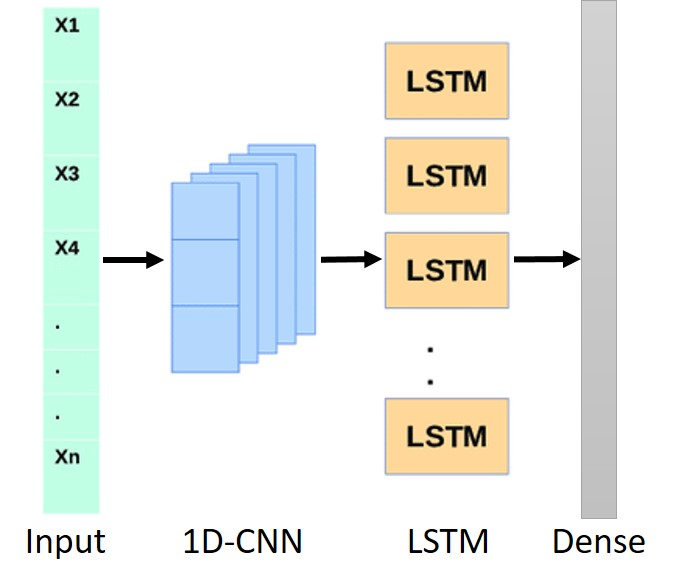

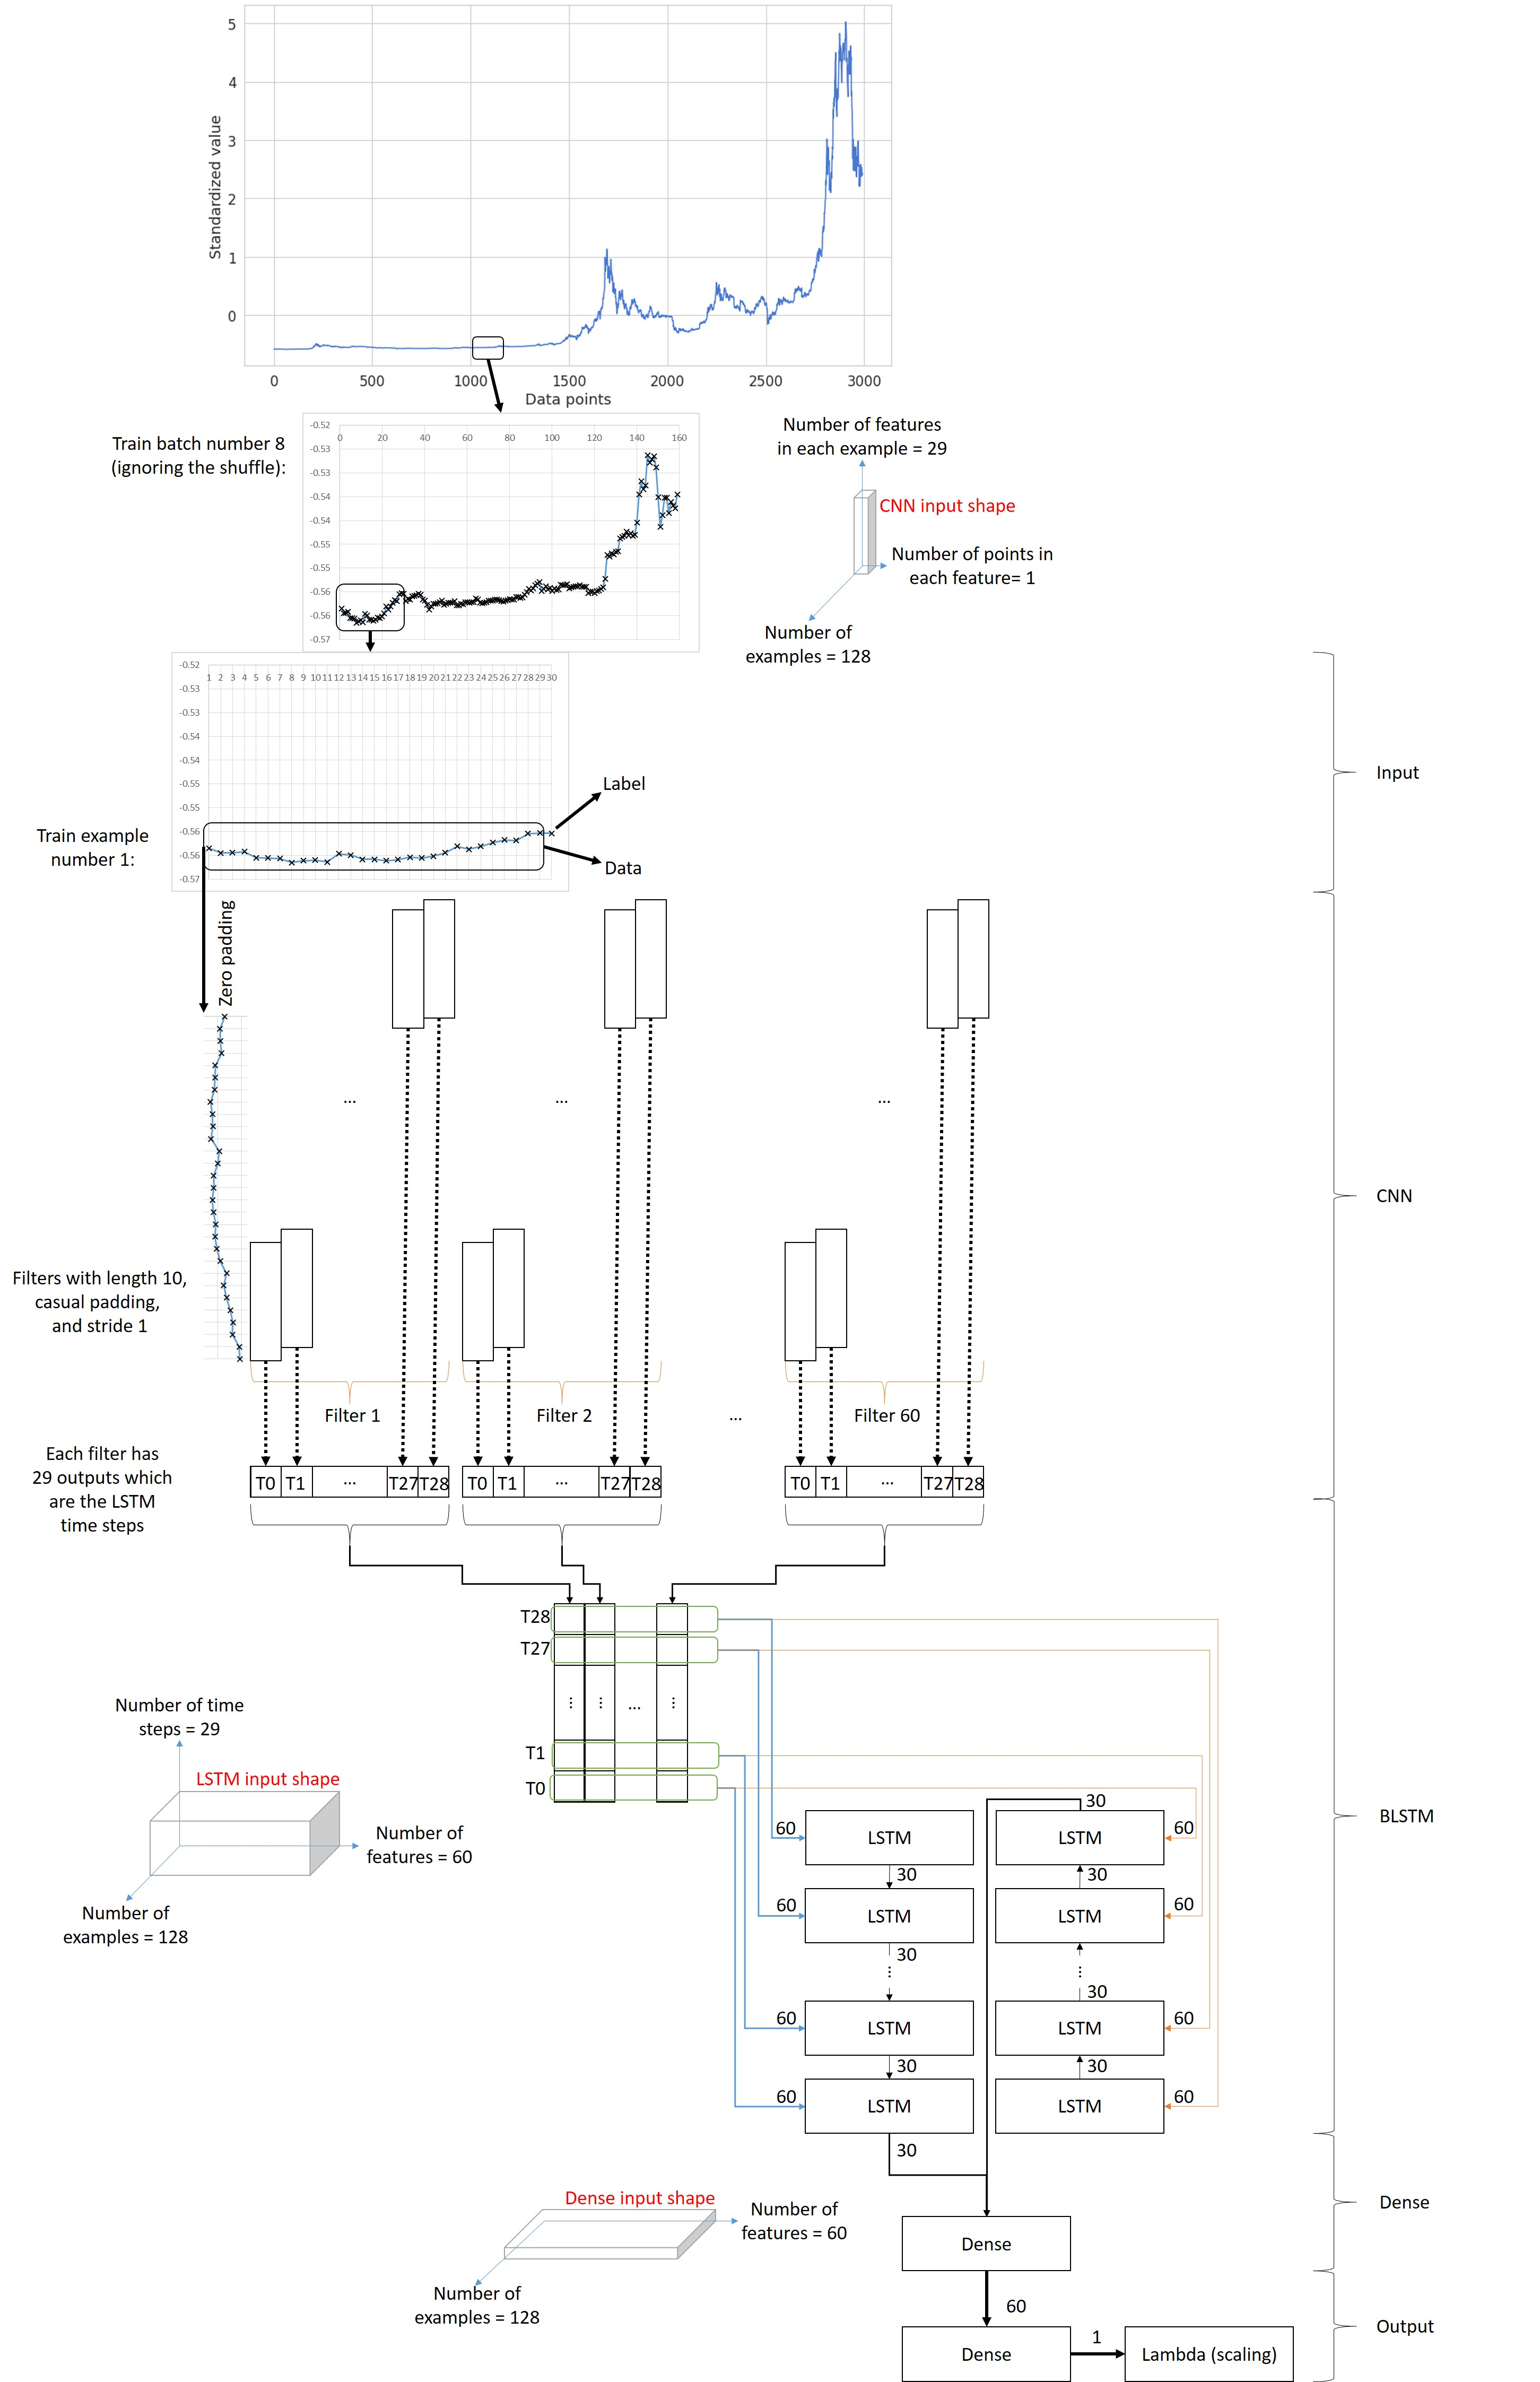

In [ ]:
"""
Develop the nn
"""

# callbacks for tensorBoard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# define the nn
# Conv1D input_shape is batch_shape + (steps, input_dim), specify only the 
# steps and the number of features (none to indicates an element to be filled
# latter by the model
# Conv1D output is batch_shape + (new_steps, filters), thefore, the input for
# the LSTM is the time steps with new features created by the CNN filters
ManyToOneModel = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=windowSize*2, kernel_size=10, strides=1, 
                         padding="causal",activation="relu", 
                         input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(windowSize, 
                       activation="tanh", 
                       return_sequences=False)),
  tf.keras.layers.Dense(windowSize*2, 
                        activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100) # scaling output
])

# compile the model
ManyToOneModel.compile(optimizer="adam", loss=tf.keras.losses.Huber(),
                          metrics=["mae"])

# check the model structure
ManyToOneModel.summary()

In [ ]:
"""
Train the model
"""

trainingHistory = ManyToOneModel.fit(trainDataset,
                                epochs=11, 
                                callbacks=[tensorboard_callback])

In [ ]:
"""
Test the model
"""

# evaluate the test dataset
forecast = model_forecast(ManyToOneModel,
                          test,
                          windowSize, batchSize)

# estimate the error
mae = mean_absolute_error(test[windowSize-1:], forecast)
print("Mean Absolute Error: " + str(mae))

# plot the forcasted and true values
plt.figure(figsize=(10, 6))
plotTimeSeries(timeToStartTest, test[windowSize-1:])
plotTimeSeries(timeToStartTest, forecast)
plt.xlabel("Data points")
plt.ylabel("Standardized value")
plt.legend(["True", "Forecast"], ncol=2)

In [ ]:
"""
Plot the loss
"""

plotLoss(trainingHistory)

In [ ]:
""""
Check caracteristics of the trained model
"""

%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
"""
Visualize the weights of the CNN layer
"""

# number of filter to plot the weights
SelectedFilter = 50

# get the weights of the CNN layer
filters = ManyToOneModel.layers[0].get_weights()[0][:, 0, SelectedFilter]

x = np.linspace(0, len(filters), num=10) # x axis

# plot the values and the weights in an line and in an image
fig, (ax0, ax1) = plt.subplots(
    nrows=2, 
    gridspec_kw={'height_ratios':[10, 10],}, 
    sharex=True)
ax0.plot(x, filters)
ax1.imshow(np.atleast_2d(filters), 
           cmap=plt.get_cmap('gray'),
           extent=(0, 10, 0, 0.5))
ax1.set_yticklabels([]) # clear the Y axis for plot 1
plt.show()